In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
from scipy import sparse
import numpy as np


def save_sparse_csr(filename, array):
    np.savez(filename, data=array.data, indices=array.indices,
             indptr=array.indptr, shape=array.shape)

def load_sparse_csr(filename):
    loader = np.load(filename)
    return sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [3]:
folder = '/dfs/scratch0/paroma/fonduer/'
F_train = load_sparse_csr(folder+'F_train.npz')
F_dev = load_sparse_csr(folder+'F_dev.npz')
train_ground = np.load(folder+'train_ground.npy')
val_ground = np.load(folder+'dev_ground.npy')

In [4]:
feat_names = np.load(folder+'feat_names.npy')
primitive_idx = [i for i in range(len(feat_names)) if (feat_names[i].startswith('STR_') or feat_names[i].startswith('TAB_') or feat_names[i].startswith('VIZ_'))]
feat_idx = list(set(range(len(feat_names))) - set(primitive_idx))

train_primitive_matrix = F_train[:,primitive_idx]
val_primitive_matrix = F_dev[:,primitive_idx]

In [5]:
from numpy import random
random.seed(124)

train_idx = random.choice(np.shape(F_train)[0],100000)
val_idx = random.choice(np.shape(F_dev)[0],100)

train_ground = train_ground[train_idx]
val_ground = val_ground[val_idx]
np.where(val_ground == 1.)

(array([ 2,  3, 12, 14, 17, 20, 21, 22, 27, 35, 36, 37, 40, 41, 44, 47, 49,
        53, 59, 66, 68, 71, 72, 73, 74, 76, 86, 90, 91, 99]),)

In [6]:
from data.loader import DataLoader
dl = DataLoader()

train_primitive_matrix = np.array(train_primitive_matrix[train_idx,:].todense())
val_primitive_matrix = np.array(val_primitive_matrix[val_idx,:].todense())

common_idx = dl.prune_features(val_primitive_matrix, train_primitive_matrix, thresh=0.05)

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [23]:
from program_synthesis.heuristic_generator import HeuristicGenerator
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []

training_marginals = []
idx = None
weights = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.5)
import time
start = time.time()
for i in range(3,20):
    print i
    if i == 3:
        hg.run_synthesizer(max_cardinality=1, idx=None, weights=weights, keep=3, model='dt')
    else:
        hg.run_synthesizer(max_cardinality=1, idx=None, weights=weights, keep=1, model='dt')
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    training_marginals.append(hg.vf.train_marginals)
    validation_coverage.append(vc)
    training_coverage.append(tc)
        
    hg.find_feedback()
    idx = hg.feedback_idx
    
    #For Rebuttal
    #weights = hg.vf.find_weighted_vague_points()
    
    if idx == []:
        break
print time.time() - start

3
867.195682049


In [28]:
np.save('/dfs/scratch0/paroma/reef/hardware_reef_5.npy', np.array(training_marginals[-1]))

(array([98311.,   612.,     0.,     0.,     0.,     0.,     0.,   198.,
            0.,   879.]),
 array([1.28555892e-04, 1.00102845e-01, 2.00077134e-01, 3.00051422e-01,
        4.00025711e-01, 5.00000000e-01, 5.99974289e-01, 6.99948578e-01,
        7.99922866e-01, 8.99897155e-01, 9.99871444e-01]),
 <a list of 10 Patch objects>)

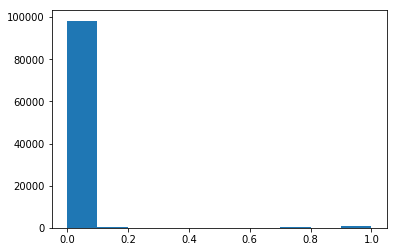

In [25]:
plt.hist(training_marginals[-1])

In [17]:
np.save('hardware_udh.npy', np.array(training_marginals))

### Visualize Heuristic Behavior

NameError: name 'dataset' is not defined

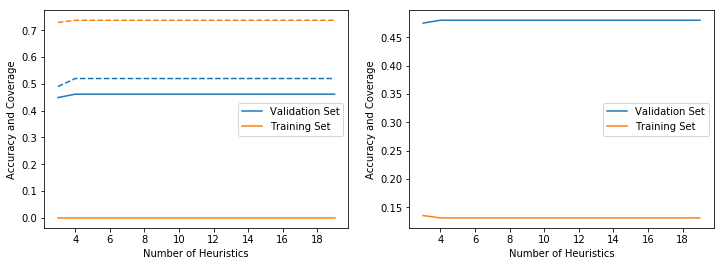

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,20),validation_accuracy, color='C0')
plt.plot(range(3,20),training_accuracy, color='C1')
plt.plot(range(3,20),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,20),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,20),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,20),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
#plt.ylim([0.55,1.0])
plt.suptitle('Dataset: ' + dataset)

In [19]:
print "Program Synthesis Train Accuracy: ", np.max(training_accuracy[1:])
print "Program Synthesis Train Coverage: ", training_coverage[1:][np.argmax(training_accuracy[1:])]
print "Number of Heuristics: ", np.argmax(training_accuracy[1:])+4

print "Program Synthesis Validation Accuracy: ", np.max(validation_accuracy[3:])

Program Synthesis Train Accuracy:  0.0
Program Synthesis Train Coverage:  0.73737
Number of Heuristics:  4
Program Synthesis Validation Accuracy:  0.46153846153846156


In [15]:
# filepath = '/dfs/scratch0/paroma/reef/' + dataset
# old_reef = np.load(filepath+'_reef_nn2.npy')

# plt.hist(old_reef, bins=10, range=[0.0,1.0], alpha=0.75)
# plt.hist(training_marginals[1], bins=10, range=[0.0,1.0], alpha=0.75)
# plt.legend(['Subset', 'Weighted'])

### Save Reef Marginals

In [20]:
filepath = '/dfs/scratch0/paroma/reef/hardware'
np.save(filepath+'_reef.npy', training_marginals[-1])

In [9]:
beta_opt = hg.syn.find_optimal_beta(hg.hf, hg.val_primitive_matrix, hg.feat_combos, hg.val_ground)
L_train_all = hg.apply_heuristics(hg.hf, primitive_matrix, hg.feat_combos, beta_opt)

from program_synthesis.verifier import Verifier
vf_temp = Verifier(L_train_all,L_train_all,train_ground, has_snorkel=False)
vf_temp.train_gen_model()
vf_temp.assign_marginals()
training_all = vf_temp.train_marginals

filepath = '/dfs/scratch0/paroma/reef/' + dataset
np.save(filepath+'_reef_pruner.npy', training_all)

## Calculate Baselines

In [3]:
# primitive_matrix = np.load('./data/mammogram/primitive_matrix.npy')
# primitive_matrix = primitive_matrix.T

[**Decision Tree**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Depth bound is unbounded, using default settings. Could do a finer comparison if needed.

In [8]:
from baselines.models import DecisionTree
dt = DecisionTree(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
dt.fit()
va,ta, vc, tc = dt.evaluate()
print "Decision Tree Train Accuracy: ", ta
print "Decision Tree Validation Accuracy: ", va

filepath = '/dfs/scratch0/paroma/reef/' + 'hardware'
np.save(filepath+'_dt_pruned.npy', dt.train_marginals)

Decision Tree Train Accuracy:  0.6385613857240452
Decision Tree Validation Accuracy:  0.925531914893617


[**Boosting (AdaBoost)**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) No bound of the number of estimators yet, could bound by number of primitives for "fair" comparison?

In [ ]:
from baselines.models import BoostClassifier
bc = BoostClassifier(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
bc.fit()
va,ta, vc, tc = bc.evaluate()
print "Boosting Train Accuracy: ", ta
print "Boosting Validation Accuracy: ", va

np.save(filepath+'_bc.npy', bc.train_marginals)

Boosting Train Accuracy:  0.72447
Boosting Validation Accuracy:  1.0


[**LabelPropagation (Normal Semi-Supervised)**](http://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading)
Semi-supervised method that is robust to noise. Fits with both the labeled and unlabeled examples

In [ ]:
from baselines.models import SemiSupervised
ss = SemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
ss.fit()
va,ta, vc, tc = ss.evaluate()
print "SemiSupervised Train Accuracy: ", ta
print "SemiSupervised Validation Accuracy: ", va

np.save(filepath+'_ss.npy', ss.train_marginals)

[**CPLE (Pessimistic Likelihood Estimation for Semi-Supervised)**](https://github.com/tmadl/semisup-learn) Based on the [model](https://arxiv.org/abs/1503.00269) that guarantees that adding in the unlabeled data points will not worsen only training with labeled examples

In [19]:
from baselines.models import ContrastiveSemiSupervised
css = ContrastiveSemiSupervised(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
css.fit()
va,ta, vc, tc = css.evaluate()
print "ContrastiveSemiSupervised Train Accuracy: ", ta
print "ContrastiveSemiSupervised Validation Accuracy: ", va

NameError: global name 'CPLELearningModel' is not defined

### Save Baseline Marginals

In [ ]:
filepath = '/dfs/scratch0/paroma/reef/' + dataset

np.save(filepath+'_dt_pruned.npy', dt.train_marginals)
np.save(filepath+'_bc.npy', bc.train_marginals)
np.save(filepath+'_ss.npy', ss.train_marginals)
#np.save(filepath+'_css.npy', css.train_marginals)

#np.save(filepath+'_gt.npy', train_ground)